# The Bank Marketing Problem  

## Client Atributes

| Column      | Description                                                                                    |
| ----------- | ---------------------------------------------------------------------------------------------- |
| `age`       | Age of the client (numeric).                                                                   |
| `job`       | Type of job (categorical). Examples: `admin.`, `technician`, `blue-collar`, `management`, etc. |
| `marital`   | Marital status (categorical). Values: `married`, `single`, `divorced`.                         |
| `education` | Education level (categorical). Values: `primary`, `secondary`, `tertiary`, `unknown`.          |
| `default`   | Has credit in default? (categorical). Values: `yes`, `no`, `unknown`.                          |
| `balance`   | Average yearly balance in euros (numeric).                                                     |
| `housing`   | Has a housing loan? (categorical). Values: `yes`, `no`, `unknown`.                             |
| `loan`      | Has a personal loan? (categorical). Values: `yes`, `no`, `unknown`.                            |

## Contact attributes

| Column     | Description                                                                                                                |
| ---------- | -------------------------------------------------------------------------------------------------------------------------- |
| `contact`  | Communication type (categorical). Values: `cellular`, `telephone`.                                                         |
| `day`      | Last contact day of the month (numeric).                                                                                   |
| `month`    | Last contact month of the year (categorical). Values: `jan`, `feb`, `mar`, etc.                                            |
| `duration` | Last campaign contact duration, in seconds (numeric).  |

## Campaing Attributes

| Column     | Description                                                                                                                           |
| ---------- | ------------------------------------------------------------------------------------------------------------------------------------- |
| `campaign` | Number of contacts performed during this campaign for this client (numeric, includes last contact).                                   |
| `pdays`    | Number of days that passed after the client was last contacted in a previous campaign (-1 means client was not previously contacted). |
| `previous` | Number of contacts performed before this campaign for this client (numeric).                                                          |
| `poutcome` | Outcome of the previous marketing campaign (categorical). Values: `success`, `failure`, `other`, `unknown`.                           |


## Dataset Exploration

A preview of the information inside the datasets:

In [12]:
# Core ML & utility imports
import numpy as np
import pandas as pd

# Optional libraries (wrapped) — notebook can run without them
try:
    import xgboost as xgb
    HAS_XGBOOST = True
except Exception:
    HAS_XGBOOST = False

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

try:
    import optuna
    HAS_OPTUNA = True
except Exception:
    HAS_OPTUNA = False

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    brier_score_loss,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
)

import requests
import zipfile
import io
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"
r = requests.get(url)

# Open the zip file in memory
z = zipfile.ZipFile(io.BytesIO(r.content))

# Extract and read "bank-full.csv"
df = pd.read_csv(z.open("bank-full.csv"), sep=";")

print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [14]:

import matplotlib.pyplot as plt
import seaborn as sns
df_sample = df.sample(n=500, random_state=42)  # random_state ensures reproducibility
df.describe()


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## Attributes Distribution


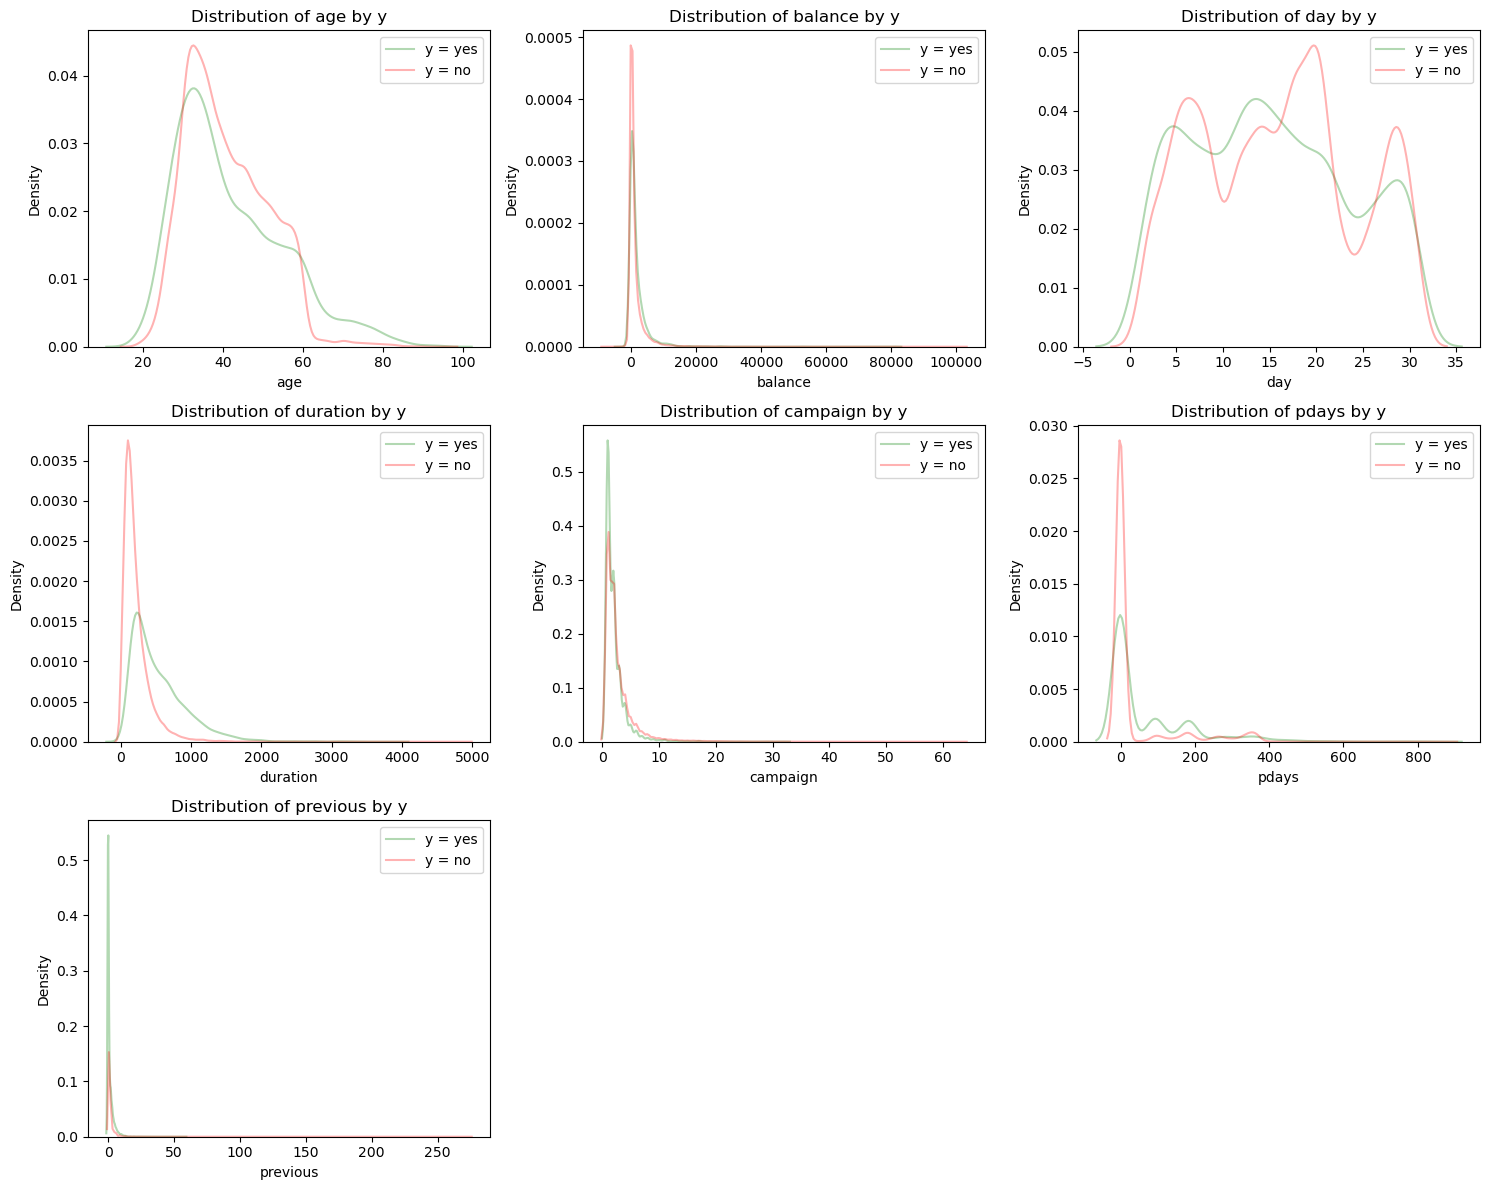

In [15]:

variables = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create a 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Loop over variables
for i, var in enumerate(variables):
    ax = axes[i]
    
    df_plot = df.copy()
    
    # Plot distributions by 'y'
    sns.kdeplot(df_plot[df_plot['y'] == 'yes'][var], ax=ax, color='green', fill=False, alpha=0.3, label='y = yes')
    sns.kdeplot(df_plot[df_plot['y'] == 'no'][var], ax=ax, color='red', fill=False, alpha=0.3, label='y = no')
    
    ax.set_title(f'Distribution of {var} by y')
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.legend()

# Remove unused axes if any
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## The high cost of campaigns

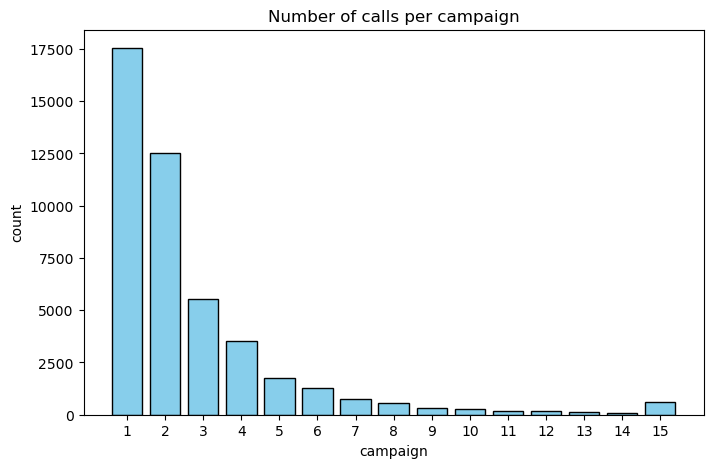

In [16]:

df['campaign_plot'] = df['campaign'].clip(upper=15)

counts = df['campaign_plot'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.title("Number of calls per campaign")
plt.xlabel("campaign")
plt.ylabel("count")
plt.xticks(
    np.arange(df['campaign_plot'].min(), df['campaign_plot'].max() + 1)
)
plt.show()


TO DO: How much money was spend on costumers that didnt pay (by maleha)

In [21]:
# Convert the 'y' column (yes/no) to numeric form if it exists
if 'y_true' not in df.columns and 'y' in df.columns:
    df['y_true'] = df['y'].map({'yes': 1, 'no': 0})


In [23]:
# Calculate total money spent on customers who didn't pay
# Make this robust: if 'call_cost' is missing, fall back to a default cost per call.
DEFAULT_CALL_COST = 2.0  # set a sensible default if your dataset doesn't include call costs

# Ensure we have a y_true column
if 'y_true' not in df.columns:
    if 'y' in df.columns:
        df['y_true'] = df['y'].map({'yes': 1, 'no': 0})
    else:
        raise RuntimeError("Neither 'y_true' nor 'y' present in dataframe. Please map the target column first.")

# If 'call_cost' column exists, use it; otherwise use default and (optionally) campaign counts
if 'call_cost' in df.columns:
    money_spent_on_non_payers = df.loc[df['y_true'] == 0, 'call_cost'].sum()
else:
    # try to estimate calls: if there's a 'campaign' column we can use it as number of calls per row
    if 'campaign' in df.columns:
        calls_non_payers = df.loc[df['y_true'] == 0, 'campaign'].sum()
    else:
        # fallback: count non-payers and assume one call each
        calls_non_payers = df.loc[df['y_true'] == 0].shape[0]
    money_spent_on_non_payers = calls_non_payers * DEFAULT_CALL_COST

print(f"💸 Total money spent on customers who didn't pay: ${money_spent_on_non_payers:,.2f}")

💸 Total money spent on customers who didn't pay: $227,264.00


In [ ]:
df['campaign_plot'].value_counts()
df = df.drop(["campaign_plot"])

campaign_plot
1     15880
2     11723
3      5181
4      3365
5      1687
6      1246
7       710
15      613
8       529
9       320
10      263
11      197
12      154
13      132
14       93
Name: count, dtype: int64

### Duration: Data Leakage


explanation of data leakage (by maleha)

The variable campaign_plot was created only for visualization purposes (to cap the campaign count at 15 for easier plotting).
However, this variable is directly derived from campaign, which already exists in the dataset.

Keeping both could introduce data leakage, meaning the model might indirectly use the same information twice, giving it an unfair advantage and making evaluation results unrealistic.

To ensure the model generalizes well to unseen data, we drop campaign_plot before training.

## Target: Subscribe or not subscribe

In [ ]:


percentages = df['y'].value_counts(normalize=True) * 100


print("Proportion in the target variable: ",percentages)

df["y"] = df["y"].map({"yes": True, "no": False})

Proportion in the target variable:  y
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


## Balance

The varible balance in the top 1% doesn't add relevant information about how different the target's distribution is compared to how it is in whole datasets. Therefore, the variable is capped in the 99th percentile. 

In [ ]:
upper_bound = df['balance'].quantile(0.99)

df_99 = df[df['balance']>= upper_bound]

percentages_outliers = df_99['y'].value_counts(normalize=True) * 100
print("Proportion when filtering the top 1% in the target variable: ",percentages_outliers)

Proportion when filtering the top 1% in the target variable:  y
False    88.07947
True     11.92053
Name: proportion, dtype: float64


In [ ]:
df['balance'] = df['balance'].clip(upper=upper_bound)

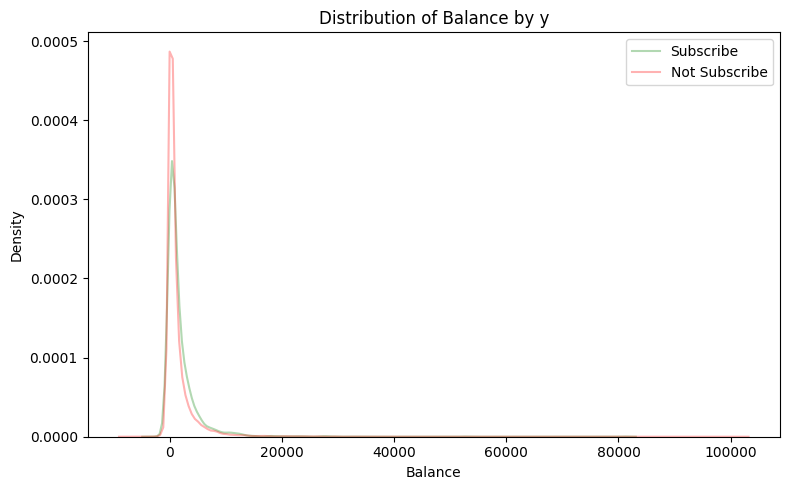

In [ ]:
plt.figure(figsize=(8,5))

# Plot KDE by 'y'
sns.kdeplot(df_plot[df_plot['y'] == 'yes']['balance'], color='green', fill=False, alpha=0.3, label='Subscribe')
sns.kdeplot(df_plot[df_plot['y'] == 'no']['balance'], color='red', fill=False, alpha=0.3, label='Not Subscribe')

plt.title('Distribution of Balance by y')
plt.xlabel('Balance')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## campaign

In the case of campaign, the first 1% of the variable have a meaningful different between the "yes" percentage compared to the overall dataset. 

In [ ]:
upper_bound = df['campaign'].quantile(0.90)

df_99 = df[df['campaign']>= upper_bound]

print(upper_bound)
percentages_outliers = df_99['y'].value_counts(normalize=True) * 100
print("Proportion when filtering the top 1% in the target variable: ",percentages_outliers)

5.0
Proportion when filtering the top 1% in the target variable:  y
False    93.593724
True      6.406276
Name: proportion, dtype: float64


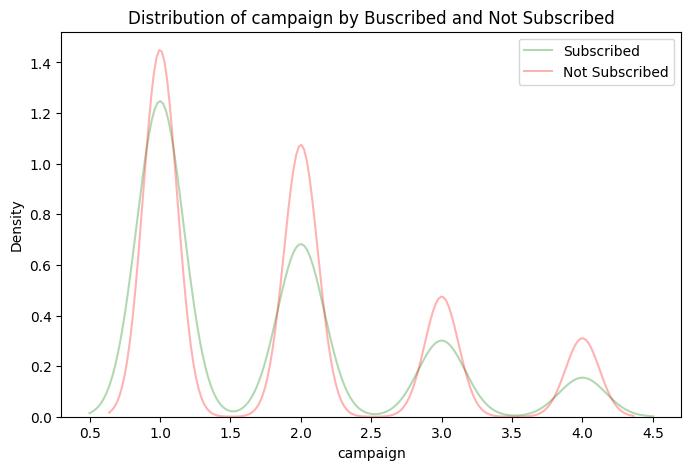

In [ ]:
name_variable = "campaign"

df_plot = df[df[name_variable] < upper_bound]
plt.figure(figsize=(8,5))

# Plot KDE by 'y'
sns.kdeplot(df_plot[df_plot['y'] == True][name_variable], color='green', fill=False, alpha=0.3, label='Subscribed')
sns.kdeplot(df_plot[df_plot['y'] == False][name_variable], color='red', fill=False, alpha=0.3, label='Not Subscribed')

plt.title(f'Distribution of {name_variable} by Buscribed and Not Subscribed')
plt.xlabel(name_variable)
plt.ylabel('Density')
plt.legend()
plt.show()

## p days

In [ ]:
upper_bound = df['pdays'].quantile(0.99)

df_99 = df[df['pdays']>= upper_bound]

print(upper_bound)
percentages_outliers = df_99['y'].value_counts(normalize=True) * 100
print("Proportion in the target variable: ",percentages_outliers)

370.0
Proportion in the target variable:  y
False    63.429752
True     36.570248
Name: proportion, dtype: float64


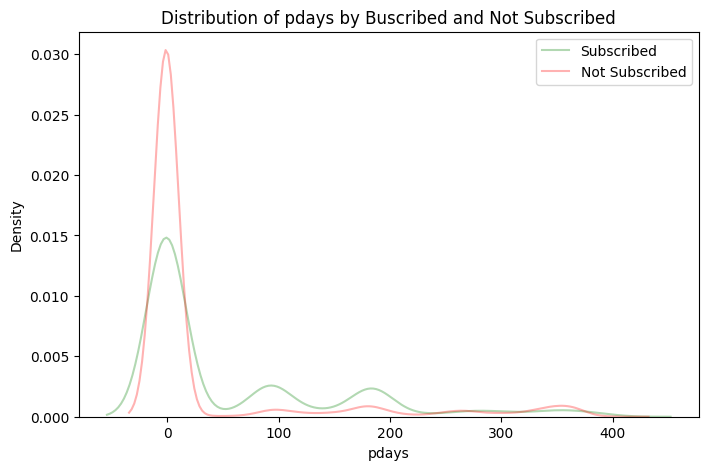

In [ ]:
name_variable = "pdays"

df_plot = df[df[name_variable] < 400]
plt.figure(figsize=(8,5))

# Plot KDE by 'y'
sns.kdeplot(df_plot[df_plot['y'] == True][name_variable], color='green', fill=False, alpha=0.3, label='Subscribed')
sns.kdeplot(df_plot[df_plot['y'] == False][name_variable], color='red', fill=False, alpha=0.3, label='Not Subscribed')

plt.title(f'Distribution of {name_variable} by Buscribed and Not Subscribed')
plt.xlabel(name_variable)
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
df['months_since_previous_contact'] = pd.cut(
    df['pdays'],
    bins=[-2,-1,150,230,310,380,1000],   # intervals
    labels=[
        "No contact",
        "0 - 5 months", "5 - 8 months", "8 - 11 months", "Around a year", "More than a year"
    ]
)

df['months_since_previous_contact'].value_counts()

months_since_previous_contact
No contact          36954
0 - 5 months         2346
5 - 8 months         2228
Around a year        2035
8 - 11 months        1353
More than a year      295
Name: count, dtype: int64

C:\Users\crist\AppData\Local\Temp\ipykernel_6444\560469242.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


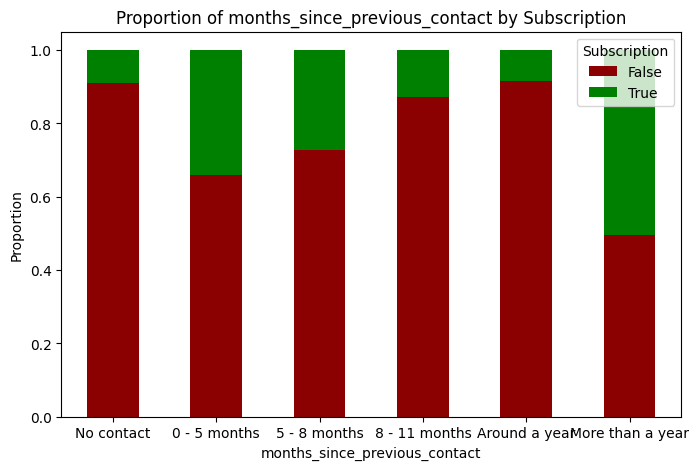

In [ ]:

name_variable = "months_since_previous_contact"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "darkred", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

## Previuos

In [ ]:
upper_bound = df['previous'].quantile(0.99)

df_99 = df[df['previous']>= upper_bound]

print(upper_bound)
percentages_outliers = df_99['y'].value_counts(normalize=True) * 100
print("Proportion in the target variable: ",percentages_outliers)

8.900000000001455
Proportion in the target variable:  y
False    77.041943
True     22.958057
Name: proportion, dtype: float64


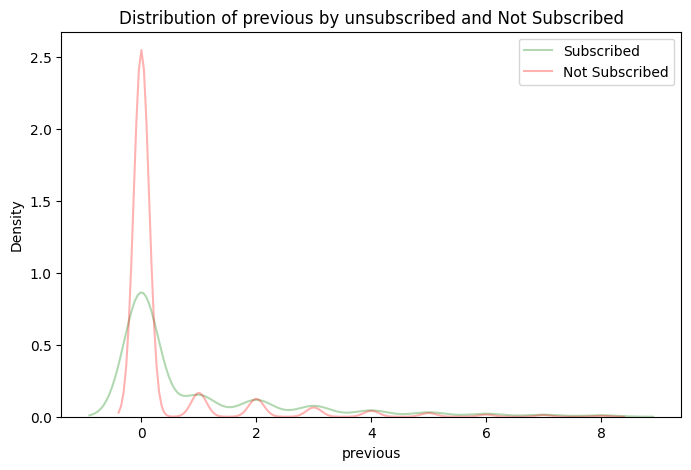

In [ ]:
%matplotlib inline


# Filter full dataframe (keep balance < 20000)

name_variable = "previous"

df_plot = df[df['previous'] < 9]
plt.figure(figsize=(8,5))

# Plot KDE by 'y'
sns.kdeplot(df_plot[df_plot['y'] == True][name_variable], color='green', fill=False, alpha=0.3, label='Subscribed')
sns.kdeplot(df_plot[df_plot['y'] == False][name_variable], color='red', fill=False, alpha=0.3, label='Not Subscribed')

plt.title(f'Distribution of {name_variable} by unsubscribed and Not Subscribed')
plt.xlabel(name_variable)
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
df['n_previous_contacts'] = pd.cut(
    df['previous'],
    bins=[-1,0,1,2,3,4,5,6,300],   # intervals
    labels=[
        "No contact",
        "1", "2", "3", "4", "5", "6",
        "More than 6"
    ]
)

df['n_previous_contacts'].value_counts()

n_previous_contacts
No contact     36954
1               2772
2               2106
3               1142
More than 6      787
4                714
5                459
6                277
Name: count, dtype: int64

C:\Users\crist\AppData\Local\Temp\ipykernel_6444\4042863158.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


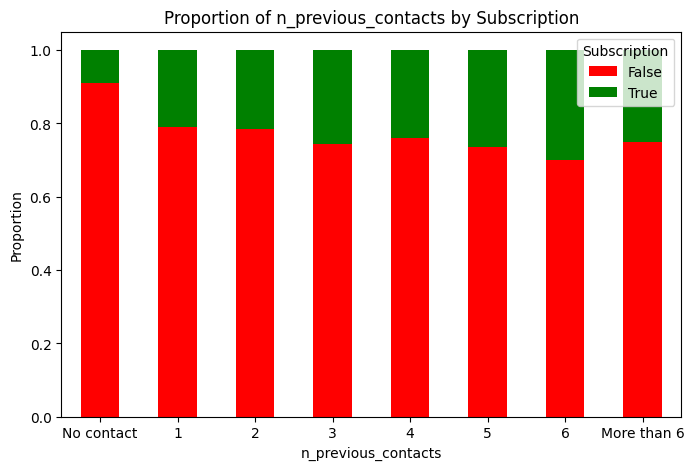

In [ ]:
name_variable = "n_previous_contacts"

counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [ ]:
count_matrix = pd.crosstab(df["n_previous_contacts"], df["months_since_previous_contact"])

# Percentages (by total)
percentage_matrix = pd.crosstab(df["n_previous_contacts"], df["months_since_previous_contact"], normalize="all") * 100

# Percentages (row-wise, if you want distribution per gender)
percentage_row = pd.crosstab(df["n_previous_contacts"], df["months_since_previous_contact"], normalize="index") * 100

print("Counts:")
print(count_matrix, "\n")

print("Percentages (overall):")
print(percentage_matrix, "\n")

print("Percentages (row-wise):")
print(percentage_row)

Counts:
months_since_previous_contact  No contact  0 - 5 months  5 - 8 months  \
n_previous_contacts                                                     
No contact                          36954             0             0   
1                                       0           685           737   
2                                       0           565           557   
3                                       0           361           311   
4                                       0           220           195   
5                                       0           161           131   
6                                       0           100            80   
More than 6                             0           254           217   

months_since_previous_contact  8 - 11 months  Around a year  More than a year  
n_previous_contacts                                                            
No contact                                 0              0                 0  
1                    

In [ ]:
df_grouped = df.groupby(["n_previous_contacts", "months_since_previous_contact"])["y"].mean()
print(df_grouped)

n_previous_contacts  months_since_previous_contact
No contact           No contact                       0.091573
                     0 - 5 months                          NaN
                     5 - 8 months                          NaN
                     8 - 11 months                         NaN
                     Around a year                         NaN
                     More than a year                      NaN
1                    No contact                            NaN
                     0 - 5 months                     0.324088
                     5 - 8 months                     0.229308
                     8 - 11 months                    0.127473
                     Around a year                    0.084918
                     More than a year                 0.632075
2                    No contact                            NaN
                     0 - 5 months                     0.313274
                     5 - 8 months                     0.276481
    

C:\Users\crist\AppData\Local\Temp\ipykernel_6444\422558207.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(["n_previous_contacts", "months_since_previous_contact"])["y"].mean()


## Correlation matrix analysis

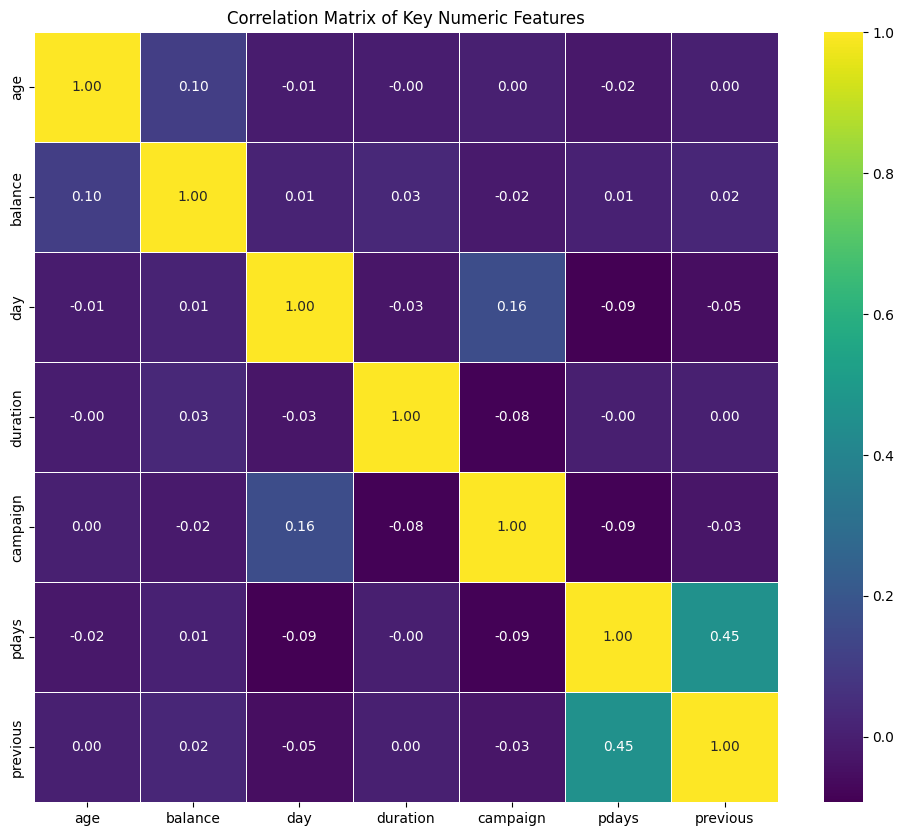

In [ ]:

corr_matrix = df[variables].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Numeric Features')
plt.show()

## Categorical Varable Analysis

### job

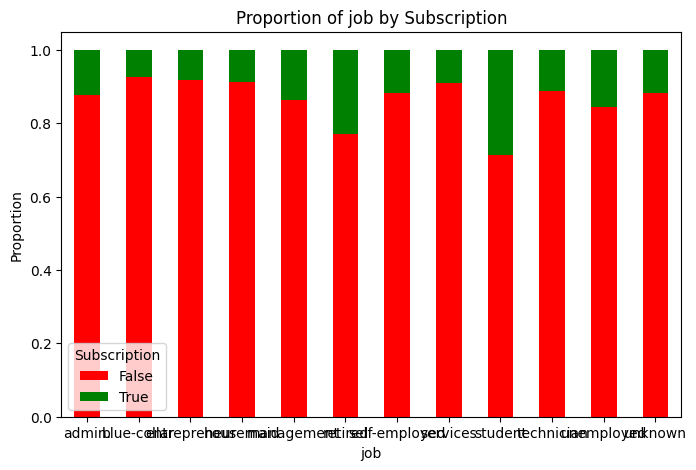

In [ ]:

name_variable = "job"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [ ]:
print(proportions)

y                 False     True 
job                              
admin.         0.877973  0.122027
blue-collar    0.927250  0.072750
entrepreneur   0.917283  0.082717
housemaid      0.912097  0.087903
management     0.862444  0.137556
retired        0.772085  0.227915
self-employed  0.881571  0.118429
services       0.911170  0.088830
student        0.713220  0.286780
technician     0.889430  0.110570
unemployed     0.844973  0.155027
unknown        0.881944  0.118056


### Marital

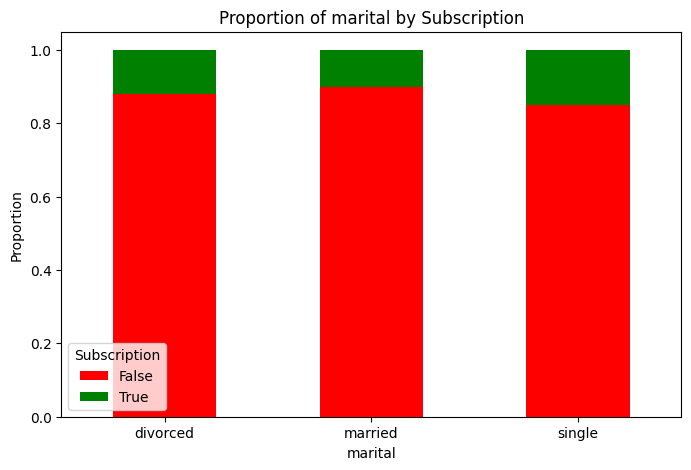

In [ ]:
name_variable = "marital"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [ ]:
print(proportions)

y            False     True 
marital                     
divorced  0.880545  0.119455
married   0.898765  0.101235
single    0.850508  0.149492


### Education


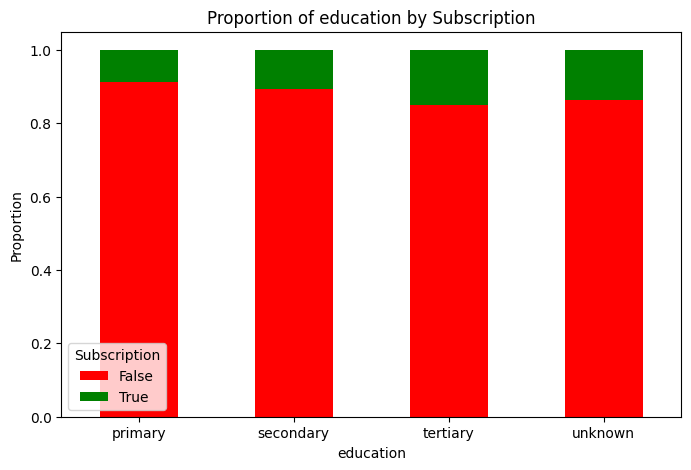

In [ ]:
name_variable = "education"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [ ]:
print(proportions)

y             False     True 
education                    
primary    0.913735  0.086265
secondary  0.894406  0.105594
tertiary   0.849936  0.150064
unknown    0.864297  0.135703


### loan

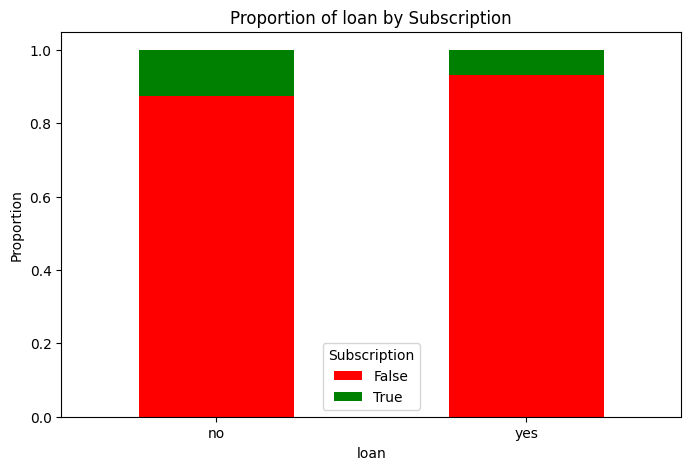

In [ ]:
name_variable = "loan"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [ ]:
print(proportions)

y        False     True 
loan                    
no    0.873443  0.126557
yes   0.933186  0.066814


### housing

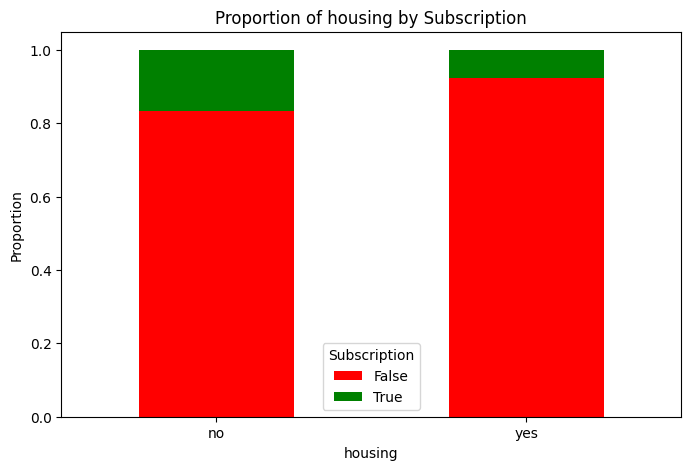

In [ ]:
name_variable = "housing"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [ ]:
print(proportions)

y           False     True 
housing                    
no       0.832976  0.167024
yes      0.923000  0.077000


### default

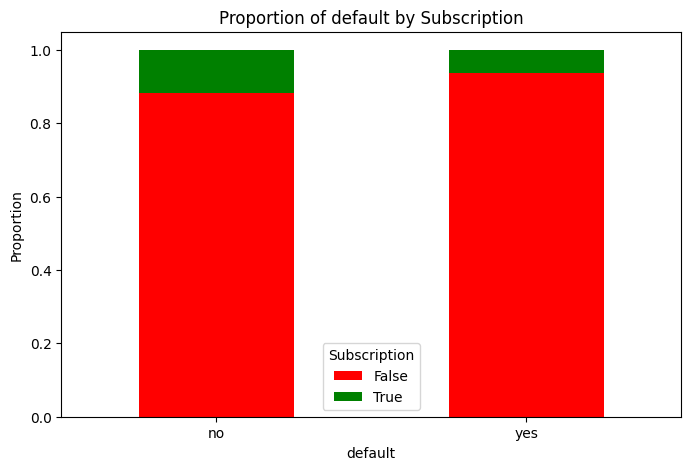

In [ ]:
name_variable = "default"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [ ]:
print(proportions)

y           False     True 
default                    
no       0.882039  0.117961
yes      0.936196  0.063804


### Contact

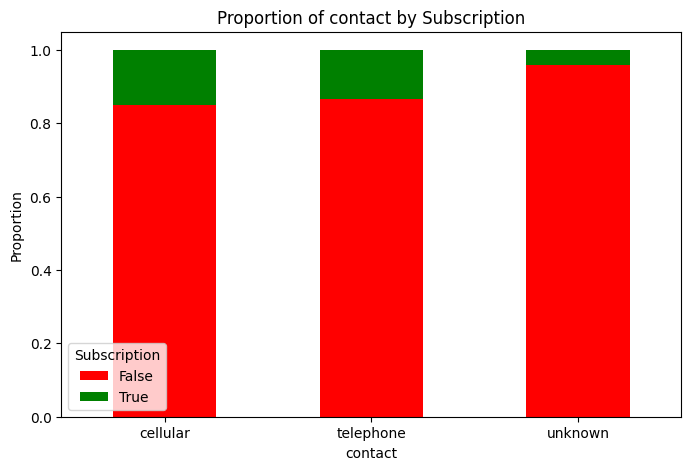

In [ ]:
name_variable = "contact"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

### poutcome

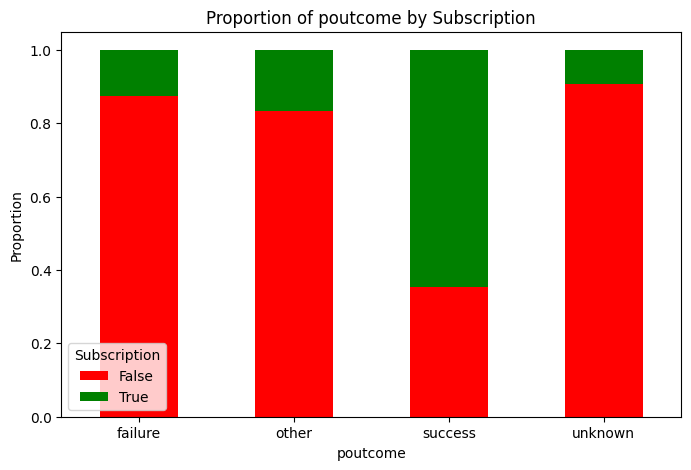

In [ ]:
name_variable = "poutcome"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

## Variable Creation

### Contact or no Contact

In [ ]:
df["had_contact"] = df["months_since_previous_contact"] != "No contact"

### Is single?

In [ ]:
df["is_single"] = df["marital"] == "single"
df["is_single"].value_counts()

is_single
False    32421
True     12790
Name: count, dtype: int64

Uknown contact information?

In [ ]:
df["uknown_contact"] = df["contact"] == "unknown"
df["uknown_contact"].value_counts()

uknown_contact
False    32191
True     13020
Name: count, dtype: int64

## Heuristic Logic

In [ ]:

df["yes_likely"] = ((df["age"] > 50) | (df["age"] < 40)) & (df["balance"] > 500) & (df["day"] < 17)

quantity = len(df[df["yes_likely"]== True])

print("quantity of potentially subscribers with a bussiness heuristic: ",quantity)


quantity of potentially subscribers with a bussiness heuristic:  6709


In [ ]:
# Just number of rows per group
df.groupby(["y", "yes_likely"]).size()



y      yes_likely
False  False         32534
       True           5868
True   False          2850
       True            841
dtype: int64

Example: We will contact those assuming they will subscribe. We won't contact the yes_likely == False (35k) which 2850 actually would have been subscribe

In [ ]:
1-(quantity/len(df))
#83,5 in model

0.8406148290689663

In [ ]:
2850/35000

0.08142857142857143

## Model

### Spliting the dataset

In [ ]:
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
 
df['month_num'] = df['month'].map(month_map)
 
# Start with 2008
year = 2008
years = []
prev_month = df['month_num'].iloc[0]
 
for m in df['month_num']:
    # If the month goes backwards (e.g., from Dec → Jan or Oct → Mar), increment year
    if m < prev_month:
        year += 1
    years.append(year)
    prev_month = m
 
df['year'] = years
 
# Finally, build datetime column
df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month_num'], day=df['day']))
 
print(df[['day','month','year','date']].head(20))

    day month  year       date
0     5   may  2008 2008-05-05
1     5   may  2008 2008-05-05
2     5   may  2008 2008-05-05
3     5   may  2008 2008-05-05
4     5   may  2008 2008-05-05
5     5   may  2008 2008-05-05
6     5   may  2008 2008-05-05
7     5   may  2008 2008-05-05
8     5   may  2008 2008-05-05
9     5   may  2008 2008-05-05
10    5   may  2008 2008-05-05
11    5   may  2008 2008-05-05
12    5   may  2008 2008-05-05
13    5   may  2008 2008-05-05
14    5   may  2008 2008-05-05
15    5   may  2008 2008-05-05
16    5   may  2008 2008-05-05
17    5   may  2008 2008-05-05
18    5   may  2008 2008-05-05
19    5   may  2008 2008-05-05


In [ ]:
df['year_month'] = pd.to_datetime(dict(year=df['year'], month=df['month_num'], day="01"))

counts_dates = df["year_month"].value_counts().sort_index()

# Percentage of total
percent = counts_dates / counts_dates.sum() * 100

# Cumulative percentage
cum_percent = percent.cumsum()

# Combine into one DataFrame
summary = pd.DataFrame({
    "n": counts_dates,
    "percent": percent,
    "cum_percent": cum_percent
})

print(summary)

               n    percent  cum_percent
year_month                              
2008-05-01  7957  17.599699    17.599699
2008-06-01  4486   9.922364    27.522063
2008-07-01  6380  14.111610    41.633673
2008-08-01  5215  11.534803    53.168477
2008-10-01    80   0.176948    53.345425
2008-11-01  3598   7.958240    61.303665
2008-12-01    13   0.028754    61.332419
2009-01-01  1176   2.601137    63.933556
2009-02-01  2296   5.078410    69.011966
2009-03-01   258   0.570658    69.582624
2009-04-01  2718   6.011811    75.594435
2009-05-01  5575  12.331070    87.925505
2009-06-01   642   1.420008    89.345513
2009-07-01   207   0.457853    89.803366
2009-08-01   772   1.707549    91.510915
2009-09-01   282   0.623742    92.134657
2009-10-01   438   0.968791    93.103448
2009-11-01   297   0.656920    93.760368
2009-12-01   201   0.444582    94.204950
2010-01-01   227   0.502090    94.707040
2010-02-01   353   0.780783    95.487824
2010-03-01   219   0.484395    95.972219
2010-04-01   214

We remove the periods that contain only a small amount of customers. Go to *Concept Check* for details. 

In [ ]:
df = df[df["year_month"] < "2009-11-01"]

In [ ]:
# df = df.drop(["marital", "contact", "month", "duration", "pdays", "previous", "poutcome", "year_month", "date", "month_num", "year"], axis=1)
# df.info()

In [ ]:
df["job"] = df["job"].astype("category")
df["education"] = df["education"].astype("category")
df["default"] = df["default"].astype("category")
df["housing"] = df["housing"].astype("category")
df["loan"] = df["loan"].astype("category")
df["poutcome"] = df["poutcome"].astype("category")


In [ ]:
numeric_features = [
    'age', 'balance', 'day', 'campaign'
]
categorical_features = ['job', 'education', 'default', "housing", "loan", "months_since_previous_contact" ,"poutcome", "n_previous_contacts" ]
boolean_features = ['had_contact', 'is_single', 'uknown_contact']

# Combine all features
all_features = numeric_features + categorical_features + boolean_features
target = 'y'

split_date_train = "2009-02-01"
split_date_test = "2009-05-01"

df_model = df.drop(["marital", "contact", "month", "duration", "pdays", "previous","date", "month_num", "year"], axis=1)

df_train = df_model[df_model["year_month"]<=split_date_train]

df_validation = df_model[(df_model["year_month"]>split_date_train)&(df_model["year_month"]<split_date_test)]

df_test = df_model[df_model["year_month"]>= split_date_test]

df_train = df_train.drop("year_month", axis = 1)
df_validation = df_validation.drop("year_month", axis = 1)
df_test = df_test.drop("year_month", axis = 1)

print(f"Training set shape:   {df_train.shape}")
print(f"Validation set shape: {df_validation.shape}")
print(f"Test set shape:       {df_test.shape}")

n_total = df_train.shape[0]+df_validation.shape[0]+df_test.shape[0]
print(f"Total of rows:   {n_total}")


Training set shape:   (31201, 16)
Validation set shape: (2976, 16)
Test set shape:       (7916, 16)
Total of rows:   42093


In [ ]:

X_train = df_train.drop(columns=[target])
y_train = df_train[target]

X_val = df_validation.drop(columns=[target])
y_val = df_validation[target]

X_test = df_test.drop(columns=[target])
y_test = df_test[target]


### Pipeline

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31201 entries, 0 to 31200
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age                            31201 non-null  int64   
 1   job                            31201 non-null  category
 2   education                      31201 non-null  category
 3   default                        31201 non-null  category
 4   balance                        31201 non-null  float64 
 5   housing                        31201 non-null  category
 6   loan                           31201 non-null  category
 7   day                            31201 non-null  int64   
 8   campaign                       31201 non-null  int64   
 9   months_since_previous_contact  31201 non-null  category
 10  n_previous_contacts            31201 non-null  category
 11  had_contact                    31201 non-null  bool    
 12  is_single                      31201 

In [ ]:
# --- Baseline Model (Dummy Classifier) ---
dummy_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', DummyClassifier(strategy='stratified'))])
dummy_pipeline.fit(X_train, y_train)
y_pred_dummy_proba = dummy_pipeline.predict_proba(X_val)[:, 1]
roc_auc_dummy = roc_auc_score(y_val, y_pred_dummy_proba)
print(f"Baseline (Dummy) ROC AUC: {roc_auc_dummy:.4f}")

# --- Logistic Regression ---
logreg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))])
logreg_pipeline.fit(X_train, y_train)
y_pred_logreg_proba = logreg_pipeline.predict_proba(X_val)[:, 1]
roc_auc_logreg = roc_auc_score(y_val, y_pred_logreg_proba)
print(f"Logistic Regression ROC AUC: {roc_auc_logreg:.4f}")

# --- Random Forest ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf_proba = rf_pipeline.predict_proba(X_val)[:, 1]
roc_auc_rf = roc_auc_score(y_val, y_pred_rf_proba)
print(f"Random Forest ROC AUC: {roc_auc_rf:.4f}")



Baseline (Dummy) ROC AUC: 0.4998
Logistic Regression ROC AUC: 0.6957
Random Forest ROC AUC: 0.5966


In [ ]:

# Get the trained logistic regression model
logreg_model = logreg_pipeline.named_steps["classifier"]

# Get feature names after preprocessing
feature_names = logreg_pipeline.named_steps["preprocessor"].get_feature_names_out()

# Extract coefficients
coefficients = logreg_model.coef_[0]

# Put into a DataFrame
importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients,
    "odds_ratio": np.exp(coefficients)
}).sort_values(by="coefficient", key=abs, ascending=False)

print(importance.head(15))  # top 15 most important

                                             feature  coefficient  odds_ratio
32                             cat__poutcome_success     0.946921    2.577761
30                             cat__poutcome_failure    -0.754488    0.470251
37                        cat__n_previous_contacts_4     0.458213    1.581246
36                        cat__n_previous_contacts_3    -0.438476    0.645018
7                                 cat__job_housemaid    -0.432440    0.648924
9                                   cat__job_retired     0.423285    1.526969
26   cat__months_since_previous_contact_0 - 5 months     0.356129    1.427791
34                        cat__n_previous_contacts_1     0.349932    1.418971
12                                  cat__job_student     0.347524    1.415558
40              cat__n_previous_contacts_More than 6    -0.242381    0.784757
28  cat__months_since_previous_contact_8 - 11 months    -0.237671    0.788462
14                               cat__job_unemployed     0.23433

In [ ]:
logreg_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


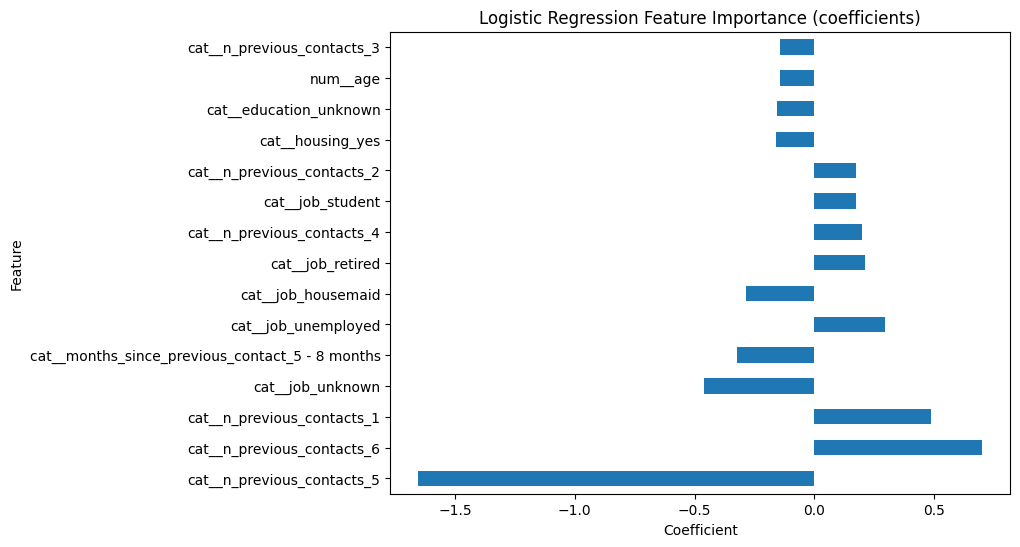

In [ ]:
import matplotlib.pyplot as plt

top_n = 15  # top features to display
importance.head(top_n).set_index("feature")["coefficient"].plot(kind="barh", figsize=(8,6))
plt.title("Logistic Regression Feature Importance (coefficients)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()


In [ ]:
# --- XGBoost (Initial) ---
# Calculate scale_pos_weight for handling imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")

if HAS_XGBOOST:
    xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', xgb.XGBClassifier(objective='binary:logistic', random_state=42,
                                                                    use_label_encoder=False, eval_metric='logloss'))])
    # We will train our final model later after choosing it
    # For now, let's just create the pipeline and train it on the train set for evaluation
    xgb_pipeline.fit(X_train, y_train)
    y_pred_xgb_proba = xgb_pipeline.predict_proba(X_val)[:, 1]
    roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb_proba)
    print(f"XGBoost (Initial) ROC AUC: {roc_auc_xgb:.4f}")
else:
    print("xgboost not installed — skipping XGBoost model training. Install with 'pip install xgboost' to enable it.")

Calculated scale_pos_weight for XGBoost: 17.42
XGBoost (Initial) ROC AUC: 0.5803


c:\Users\crist\OneDrive - Aalborg Universitet\Assignments\M1_final_assignment\final_assignment_bank_campaign\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:11:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### This is the test set metric

Final Model ROC AUC on Test Set: 0.6819


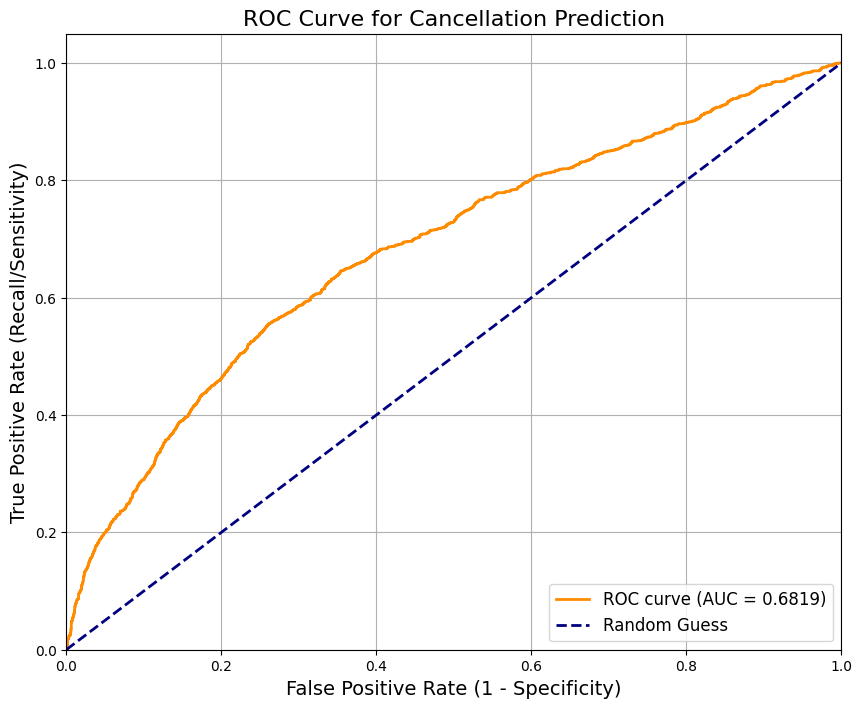

In [ ]:
y_pred_logreg_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg_proba)
final_roc_auc = roc_auc_score(y_test, y_pred_logreg_proba)

print(f"Final Model ROC AUC on Test Set: {final_roc_auc:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {final_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
plt.ylabel('True Positive Rate (Recall/Sensitivity)', fontsize=14)
plt.title('ROC Curve for Cancellation Prediction', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
df_result = X_test.copy()  # copy features
df_result["y"] = y_test.values   # add true labels
df_result["y_pred_proba"] = y_pred_logreg_proba 

df_result_sorted = df_result.sort_values(by = "y_pred_proba", ascending= True)
df_result_sorted.head(8)

,age,job,education,default,balance,housing,loan,day,campaign,poutcome,months_since_previous_contact,n_previous_contacts,had_contact,is_single,uknown_contact,y,y_pred_proba
38371,58,housemaid,primary,no,260.0,yes,no,15,5,failure,Around a year,3,True,False,False,False,0.111153
34679,51,blue-collar,primary,no,565.0,yes,yes,5,7,failure,8 - 11 months,3,True,False,False,False,0.115634
38605,60,blue-collar,primary,no,14.0,yes,yes,15,4,failure,5 - 8 months,3,True,False,False,False,0.117356
36656,47,services,secondary,no,311.0,yes,yes,12,1,failure,8 - 11 months,3,True,False,False,False,0.136610
36223,43,services,secondary,no,-416.0,yes,yes,11,1,failure,8 - 11 months,3,True,False,False,False,0.138456
38426,52,blue-collar,primary,no,134.0,yes,no,15,2,failure,8 - 11 months,3,True,False,False,False,0.142881
35001,38,housemaid,primary,no,0.0,yes,yes,6,2,failure,5 - 8 months,More than 6,True,False,False,False,0.144080
38669,46,services,secondary,no,-119.0,yes,no,15,2,failure,8 - 11 months,3,True,False,False,False,0.151348


max return threshold: 0.61


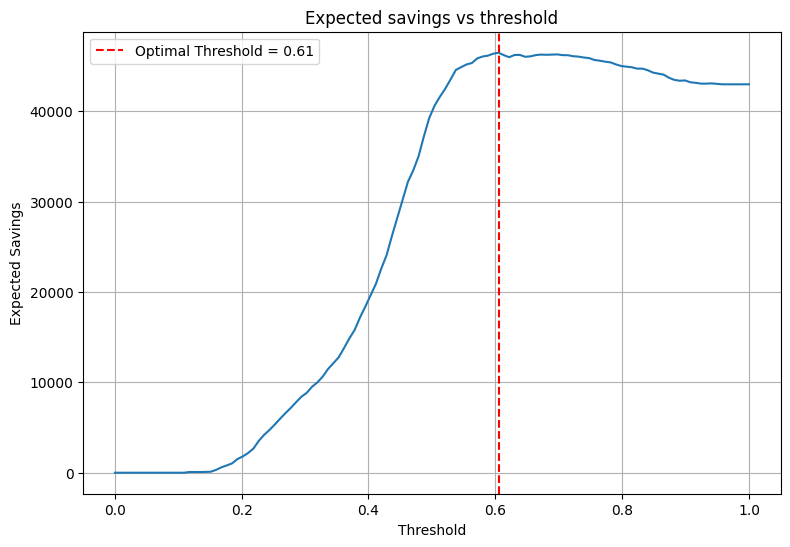

In [ ]:
C_FP = 5   # saving
C_FN = 30  # cost of missing a true subscriber

thresholds = np.linspace(0, 1, 120)

def expected_return(df, t, c_fp=C_FP, c_fn=C_FN):
    df_temp = df[df["y_pred_proba"]<=t].copy()
    total_campaigns = df_temp["campaign"].sum()
    df_temp["incorrect_pred"] = df_temp["y"]==True
    total_failed = df_temp["incorrect_pred"].sum()
    
    return total_campaigns * c_fp - total_failed * c_fn

exp_return = np.array([expected_return(df_result_sorted, t) for t in thresholds])

exp_return
t_star = float(thresholds[exp_return.argmax()])

print(f"max return threshold: {t_star:.2f}")

plt.figure(figsize=(9, 6))
plt.plot(thresholds, exp_return)
plt.xlabel("Threshold")
plt.ylabel("Expected Savings")
plt.title("Expected savings vs threshold")
plt.grid(True)
plt.axvline(x=t_star, color='r', linestyle='--', label=f'Optimal Threshold = {t_star:.2f}')
plt.legend()
plt.show()

In [ ]:
t_star

0.6050420168067226

If the probability is above t_star then is True the prediction of Subscription



Classification Report on Test Set (Threshold = 0.61):
              precision    recall  f1-score   support

       False       0.86      0.88      0.87      6495
        True       0.38      0.35      0.36      1421

    accuracy                           0.78      7916
   macro avg       0.62      0.61      0.62      7916
weighted avg       0.77      0.78      0.78      7916



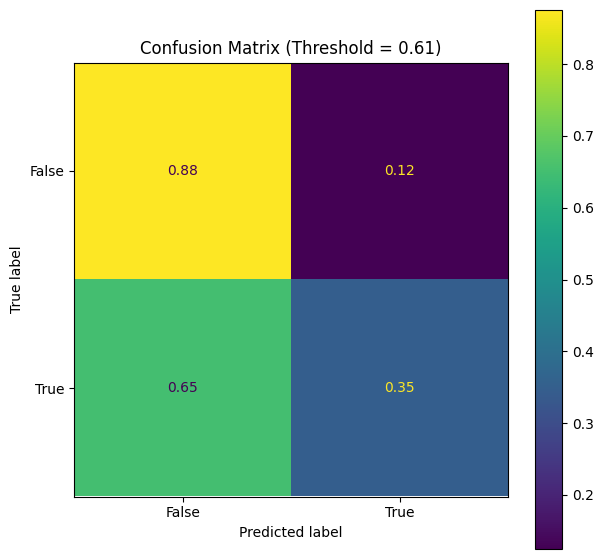

In [ ]:

y_pred_star = (y_pred_logreg_proba >= t_star).astype(int)
print(f"Classification Report on Test Set (Threshold = {t_star:.2f}):")
print(classification_report(y_test, y_pred_star))

fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_star, normalize='true', ax=ax)
ax.set_title(f'Confusion Matrix (Threshold = {t_star:.2f})')
plt.show()

In [ ]:
print("costumers don't include in campaign:")
len(df_result_sorted[df_result_sorted["y_pred_proba"] < t_star])


costumers don't include in campaign:


6613

In [ ]:
print("total of costumers:")
len(df_result_sorted)

total of costumers:


7916

In [ ]:
6613/7916

0.8353966649823144

In [ ]:
import joblib
model_filename = f'model_1mvp.pkl'

# Save the final pipeline object
joblib.dump(logreg_pipeline, model_filename)
print(f"Model pipeline saved successfully to '{model_filename}'")

# Example of loading the model back
#loaded_pipeline = joblib.load(model_filename)
#print("Model loaded successfully.")

Model pipeline saved successfully to 'model_1mvp.pkl'


## business impact analysis (by maleha)

=== BASELINE RESULTS ===
Optimal threshold: 0.66
Expected profit: $0.00
ROI: 0.00
Calls made: 0


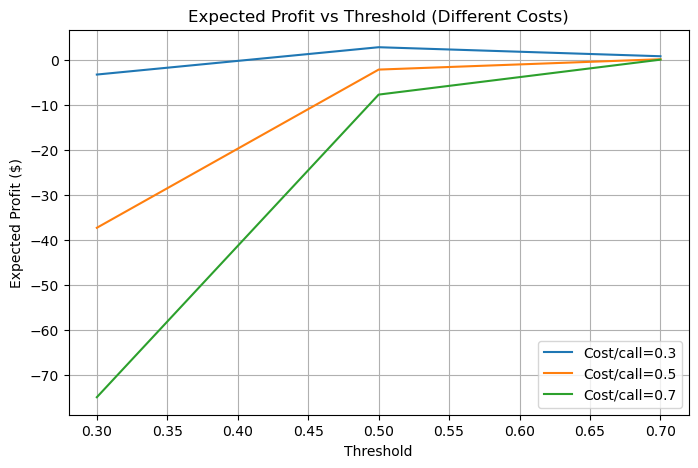

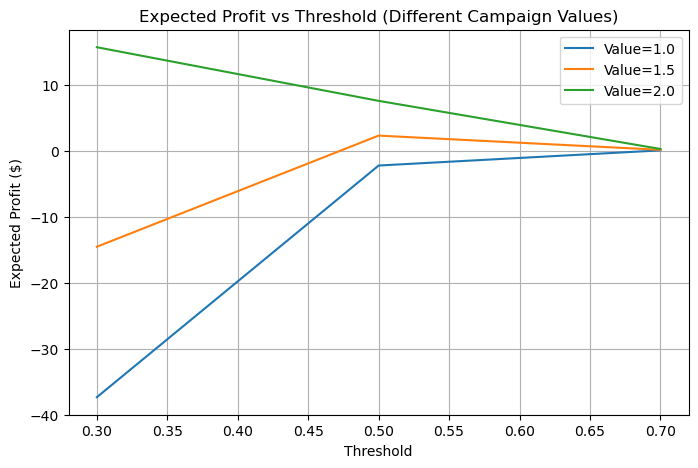


=== WHAT-IF SCENARIO SUMMARY ===
    cost_per_call  value_per_conversion  model_noise  threshold  \
0             0.3                   1.0         0.05        0.3   
1             0.3                   1.0         0.12        0.5   
2             0.3                   1.0         0.20        0.7   
3             0.3                   1.5         0.05        0.3   
4             0.3                   1.5         0.12        0.3   
5             0.3                   1.5         0.20        0.3   
6             0.3                   2.0         0.05        0.3   
7             0.3                   2.0         0.12        0.3   
8             0.3                   2.0         0.20        0.3   
9             0.5                   1.0         0.05        0.5   
10            0.5                   1.0         0.12        0.7   
11            0.5                   1.0         0.20        0.7   
12            0.5                   1.5         0.05        0.3   
13            0.5           

C:\Users\MALEHA\AppData\Local\Temp\ipykernel_32448\2885713157.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g['expected_profit'].idxmax()])


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================
# PARAMETERS (you can adjust)
# =============================
n_customers = 1000
base_cost_per_call = 0.5
base_value_per_conversion = 1.0
noise_std = 0.12  # model accuracy (lower = more accurate)

np.random.seed(42)

# =============================
# STEP 1: Create synthetic dataset
# =============================
a, b = 1.5, 8
true_probs = np.random.beta(a, b, size=n_customers)
predicted_probs = np.clip(true_probs + np.random.normal(0, noise_std, size=n_customers), 0, 1)

df = pd.DataFrame({
    "customer_id": np.arange(1, n_customers+1),
    "true_prob": true_probs,
    "predicted_prob": predicted_probs
})

# =============================
# STEP 2: Business impact function
# =============================
def campaign_profit(df, threshold, cost_per_call, value_per_conversion):
    called = df[df['predicted_prob'] >= threshold]
    n_called = len(called)
    expected_revenue = called['true_prob'].sum() * value_per_conversion
    expected_cost = n_called * cost_per_call
    profit = expected_revenue - expected_cost
    roi = (profit / expected_cost) if expected_cost > 0 else 0
    return {
        "threshold": threshold,
        "n_called": n_called,
        "expected_revenue": expected_revenue,
        "expected_cost": expected_cost,
        "expected_profit": profit,
        "ROI": roi
    }

# =============================
# STEP 3: Baseline analysis
# =============================
thresholds = np.linspace(0, 0.99, 100)
base_results = [campaign_profit(df, t, base_cost_per_call, base_value_per_conversion) for t in thresholds]
base_df = pd.DataFrame(base_results)
best_row = base_df.loc[base_df['expected_profit'].idxmax()]

print("=== BASELINE RESULTS ===")
print(f"Optimal threshold: {best_row['threshold']:.2f}")
print(f"Expected profit: ${best_row['expected_profit']:.2f}")
print(f"ROI: {best_row['ROI']:.2f}")
print(f"Calls made: {int(best_row['n_called'])}")

# =============================
# STEP 4: What-if Scenarios
# =============================

def what_if_scenarios(df, thresholds, cost_values, campaign_values, noise_levels):
    scenarios = []
    for cost in cost_values:
        for val in campaign_values:
            for noise in noise_levels:
                # Adjust model accuracy
                df['predicted_prob'] = np.clip(df['true_prob'] + np.random.normal(0, noise, size=len(df)), 0, 1)
                for t in thresholds:
                    r = campaign_profit(df, t, cost, val)
                    r.update({"cost_per_call": cost, "value_per_conversion": val, "model_noise": noise})
                    scenarios.append(r)
    return pd.DataFrame(scenarios)

# Example what-if parameter sets
cost_values = [0.3, 0.5, 0.7]              # lower / normal / higher call cost
campaign_values = [1.0, 1.5, 2.0]          # different campaign values
noise_levels = [0.05, 0.12, 0.2]           # different model accuracy levels

whatif_df = what_if_scenarios(df, [0.3, 0.5, 0.7], cost_values, campaign_values, noise_levels)

# =============================
# STEP 5: Visualize impact
# =============================

plt.figure(figsize=(8,5))
for c in cost_values:
    subset = whatif_df[(whatif_df['cost_per_call'] == c) & (whatif_df['model_noise'] == 0.12) & (whatif_df['value_per_conversion'] == 1.0)]
    plt.plot(subset['threshold'], subset['expected_profit'], label=f"Cost/call={c}")
plt.title("Expected Profit vs Threshold (Different Costs)")
plt.xlabel("Threshold")
plt.ylabel("Expected Profit ($)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
for v in campaign_values:
    subset = whatif_df[(whatif_df['value_per_conversion'] == v) & (whatif_df['model_noise'] == 0.12) & (whatif_df['cost_per_call'] == 0.5)]
    plt.plot(subset['threshold'], subset['expected_profit'], label=f"Value={v}")
plt.title("Expected Profit vs Threshold (Different Campaign Values)")
plt.xlabel("Threshold")
plt.ylabel("Expected Profit ($)")
plt.legend()
plt.grid(True)
plt.show()

# =============================
# STEP 6: Summary outputs
# =============================

summary = (
    whatif_df.groupby(['cost_per_call', 'value_per_conversion', 'model_noise'])
    .apply(lambda g: g.loc[g['expected_profit'].idxmax()])
    .reset_index(drop=True)
)

print("\n=== WHAT-IF SCENARIO SUMMARY ===")
print(summary[['cost_per_call','value_per_conversion','model_noise','threshold','expected_profit','ROI','n_called']])

# Optional: Save to CSV
whatif_df.to_csv('whatif_scenarios.csv', index=False)
summary.to_csv('whatif_summary.csv', index=False)
print("\nSaved files: whatif_scenarios.csv and whatif_summary.csv")


## ROI (by maleha)

In [ ]:
import pandas as pd

# Example data: replace this with your actual campaign dataset
# You should already have columns like ['y_pred', 'y_true', 'call_cost', 'campaign_value']
# y_pred: model's prediction (probability of success)
# y_true: actual result (1 = success, 0 = fail)
# call_cost: how much each call costs
# campaign_value: revenue earned if the call is successful

# Example dummy data
data = {
    'y_pred': [0.2, 0.8, 0.4, 0.9, 0.6],
    'y_true': [0, 1, 0, 1, 1],
    'call_cost': [2, 2, 2, 2, 2],
    'campaign_value': [10, 10, 10, 10, 10]
}
df = pd.DataFrame(data)

# Assume we only call leads above a certain predicted probability threshold
threshold = 0.5
df['called'] = df['y_pred'] >= threshold

# Calculate totals
total_calls = df['called'].sum()
total_cost = (df['call_cost'] * df['called']).sum()
total_revenue = (df['campaign_value'] * df['y_true'] * df['called']).sum()

# Calculate net profit and ROI
net_profit = total_revenue - total_cost
roi = (net_profit / total_cost) if total_cost > 0 else 0

print("=== Business Impact Analysis ===")
print(f"Total calls made: {total_calls}")
print(f"Total campaign cost: ${total_cost}")
print(f"Total revenue: ${total_revenue}")
print(f"Net profit: ${net_profit}")
print(f"ROI: {roi:.2f}")


=== Business Impact Analysis ===
Total calls made: 3
Total campaign cost: $6
Total revenue: $30
Net profit: $24
ROI: 4.00


## what if scenarios (by maleha)

=== Top 5 Thresholds by Profit ===


,Threshold,Calls Made,Revenue,Cost,Net Profit,ROI
10,0.50,3,30,6,24,4.00
11,0.55,3,30,6,24,4.00
9,0.45,3,30,6,24,4.00
5,0.25,4,30,8,22,2.75
8,0.40,4,30,8,22,2.75


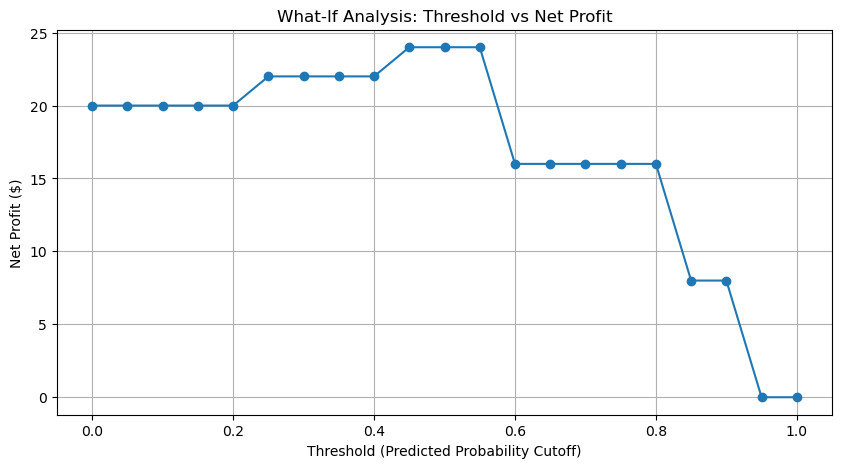

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0, 1.05, 0.05)
results = []

for t in thresholds:
    df['called'] = df['y_pred'] >= t
    total_calls = df['called'].sum()
    total_cost = (df['call_cost'] * df['called']).sum()
    total_revenue = (df['campaign_value'] * df['y_true'] * df['called']).sum()
    net_profit = total_revenue - total_cost
    roi = (net_profit / total_cost) if total_cost > 0 else 0
    results.append((t, total_calls, total_revenue, total_cost, net_profit, roi))

what_if_df = pd.DataFrame(results, columns=['Threshold', 'Calls Made', 'Revenue', 'Cost', 'Net Profit', 'ROI'])

# Display the top 5 thresholds by profit
print("=== Top 5 Thresholds by Profit ===")
display(what_if_df.sort_values(by='Net Profit', ascending=False).head())

# Plot
plt.figure(figsize=(10,5))
plt.plot(what_if_df['Threshold'], what_if_df['Net Profit'], marker='o')
plt.title("What-If Analysis: Threshold vs Net Profit")
plt.xlabel("Threshold (Predicted Probability Cutoff)")
plt.ylabel("Net Profit ($)")
plt.grid(True)
plt.show()


## finding the best threshhold (by maleha)

=== 📈 Optimal Thresholds ===
Best threshold by PROFIT: 1.00
→ Profit: $0.00, ROI: 0.00, Calls made: 0

Best threshold by ROI: 1.00
→ Profit: $0.00, ROI: 0.00, Calls made: 0


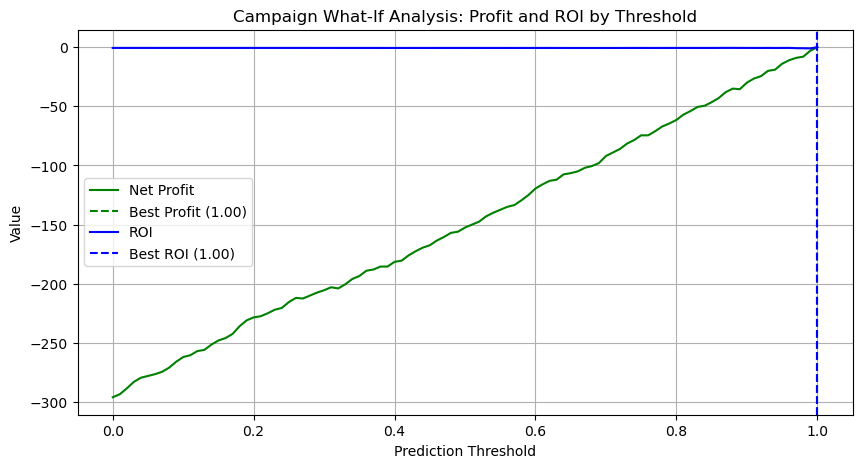

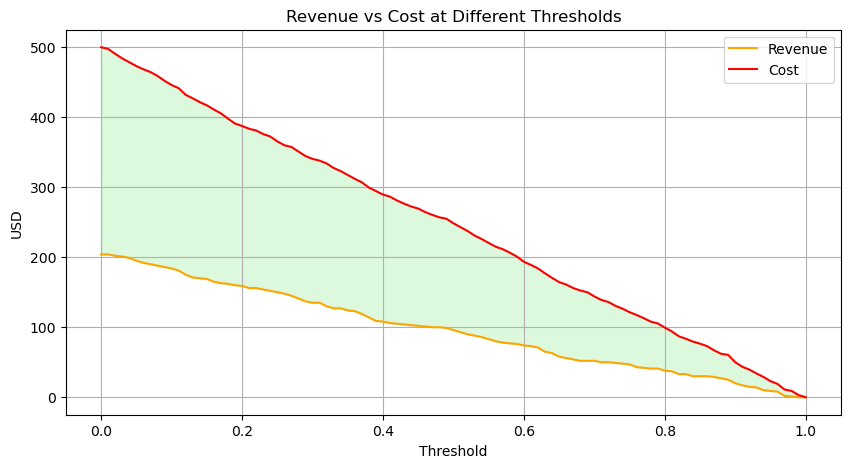


=== 🧠 Business Interpretation ===
1️⃣ The campaign is most profitable when we call customers with a predicted probability ≥ 1.00.
   - At this point, we make $0.00 in total profit.
   - We call 0 customers, meaning we’re focusing only on high-quality leads.

2️⃣ The best ROI (return on investment) occurs at threshold 1.00, where each $1 spent returns 0.00x back.
   - This often means fewer calls but more efficient targeting.

3️⃣ If you visualize the Net Profit and ROI curves, you'll see a trade-off: lower thresholds increase calls and revenue but may reduce profit per call.
Consider selecting a threshold that balances total profit and ROI given your campaign constraints.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example dummy data (replace with your own)
np.random.seed(42)
data = {
    'y_pred': np.random.rand(1000),          # model predictions
    'y_true': np.random.choice([0, 1], 1000, p=[0.8, 0.2]),  # true outcomes
}

df = pd.DataFrame(data)

# Define cost per call and revenue per successful conversion
df['call_cost'] = 0.5
df['campaign_value'] = 1.0

# Range of thresholds to test
thresholds = np.arange(0, 1.01, 0.01)
results = []

for t in thresholds:
    df['called'] = df['y_pred'] >= t
    total_calls = df['called'].sum()
    total_cost = (df['call_cost'] * df['called']).sum()
    total_revenue = (df['campaign_value'] * df['y_true'] * df['called']).sum()
    net_profit = total_revenue - total_cost
    roi = (net_profit / total_cost) if total_cost > 0 else 0
    results.append((t, total_calls, total_revenue, total_cost, net_profit, roi))

# Turn results into a DataFrame
analysis_df = pd.DataFrame(results, columns=['Threshold', 'Calls Made', 'Revenue', 'Cost', 'Net Profit', 'ROI'])

# Find optimal thresholds
best_profit_row = analysis_df.loc[analysis_df['Net Profit'].idxmax()]
best_roi_row = analysis_df.loc[analysis_df['ROI'].idxmax()]

print("=== 📈 Optimal Thresholds ===")
print(f"Best threshold by PROFIT: {best_profit_row['Threshold']:.2f}")
print(f"→ Profit: ${best_profit_row['Net Profit']:.2f}, ROI: {best_profit_row['ROI']:.2f}, Calls made: {int(best_profit_row['Calls Made'])}")
print(f"\nBest threshold by ROI: {best_roi_row['Threshold']:.2f}")
print(f"→ Profit: ${best_roi_row['Net Profit']:.2f}, ROI: {best_roi_row['ROI']:.2f}, Calls made: {int(best_roi_row['Calls Made'])}")

# ================================
# Visual Analysis
# ================================

plt.figure(figsize=(10, 5))
plt.plot(analysis_df['Threshold'], analysis_df['Net Profit'], label='Net Profit', color='green')
plt.axvline(best_profit_row['Threshold'], color='green', linestyle='--', label=f'Best Profit ({best_profit_row["Threshold"]:.2f})')

plt.plot(analysis_df['Threshold'], analysis_df['ROI'], label='ROI', color='blue')
plt.axvline(best_roi_row['Threshold'], color='blue', linestyle='--', label=f'Best ROI ({best_roi_row["Threshold"]:.2f})')

plt.title("Campaign What-If Analysis: Profit and ROI by Threshold")
plt.xlabel("Prediction Threshold")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Optional extra visualization: revenue vs cost
plt.figure(figsize=(10,5))
plt.plot(analysis_df['Threshold'], analysis_df['Revenue'], label='Revenue', color='orange')
plt.plot(analysis_df['Threshold'], analysis_df['Cost'], label='Cost', color='red')
plt.fill_between(analysis_df['Threshold'], analysis_df['Revenue'], analysis_df['Cost'], color='lightgreen', alpha=0.3)
plt.title("Revenue vs Cost at Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

# ================================
# Business Summary
# ================================
print("\n=== 🧠 Business Interpretation ===")
print(f"1️⃣ The campaign is most profitable when we call customers with a predicted probability ≥ {best_profit_row['Threshold']:.2f}.")
print(f"   - At this point, we make ${best_profit_row['Net Profit']:.2f} in total profit.")
print(f"   - We call {int(best_profit_row['Calls Made'])} customers, meaning we’re focusing only on high-quality leads.")

print(f"\n2️⃣ The best ROI (return on investment) occurs at threshold {best_roi_row['Threshold']:.2f}, where each $1 spent returns {best_roi_row['ROI']:.2f}x back.")
print("   - This often means fewer calls but more efficient targeting.")

print("\n3️⃣ If you visualize the Net Profit and ROI curves, you'll see a trade-off: lower thresholds increase calls and revenue but may reduce profit per call.")
print("Consider selecting a threshold that balances total profit and ROI given your campaign constraints.")

## Concept Check 

* We remove the periods that contain only a small amount of customers because we assumed that the campaign suffered a change in its structure, because in the first months a bigger amount of people should have worked on calling all the customers and after that, they should start calling the new customers. Additionally, we remove those periods to avoid having a long time difference between the training data and the test data.  
  
* We used a logistic regression model because tree-based algorithms showed lower performance. Our main evaluation metric was the AUC, which reached approximately 0.7 on the validation set and remained at a similar level on the test set, giving us confidence in the model’s stability over time. Additionally, this level of performance is sufficient to generate monetary value for the campaign.

## What if escenarios (for streamlit)

In [ ]:
* As a concecuence that data is ordered by time, we decided to train with the first 60% 

## LLM Usage Log 

* For solving errors in code  
* Adding X scale in plots